In [1]:
import sys
import os

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/2025_data"))
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/NiCf/offline_trigger"))
sys.path.append('/eos/home-d/dcostasr/SWAN_projects/software/hipy')
sys.path.append("/eos/home-d/dcostasr/SWAN_projects/software/wcte_software/")

import hipy.pltext       as pltext
import hipy.utils        as ut
import matplotlib.pyplot as plt
import awkward           as ak
import numpy             as np
import matplotlib.colors as colors

from src.read_data                   import load_concatenated, read_parquet, nHits
from tqdm.notebook                   import tqdm
from WCTE_event_display.EventDisplay import EventDisplay
from scipy.special import factorial


%load_ext autoreload
%autoreload 2

pltext.style()

## Read Data

In [2]:
# ============= LOADS THE DATA ===================
bkg_run  = 2384
bkg_data = load_concatenated(outdir=f"/eos/home-d/dcostasr/SWAN_projects/AmBe/tmp_parquet/{bkg_run}_calibrated")
print("Data Loaded")

# =============== MASK OUT CARDS 130-132 ===================
bkg_run_cards, bkg_run_channels, bkg_run_slots, bkg_run_positions, bkg_run_times, bkg_run_events, bkg_run_charges, bkg_run_window_times = read_parquet(bkg_data, mask=True)
print("Data Masked")

bkg_run_times_sorted = ak.sort(bkg_run_times) - bkg_run_window_times
bkg_run_window_times_sorted = ak.sort(bkg_run_window_times, axis=0)

Data Loaded
Data Masked


In [3]:
# ============= LOADS THE DATA ===================
ambe_run  = 2389
ambe_data = load_concatenated(outdir=f"/eos/home-d/dcostasr/SWAN_projects/AmBe/tmp_parquet/{ambe_run}_calibrated")
print("Data Loaded")

# =============== MASK OUT CARDS 130-132 ===================
ambe_run_cards, ambe_run_channels, ambe_run_slots, ambe_run_positions, ambe_run_times, ambe_run_events, ambe_run_charges, ambe_run_window_times = read_parquet(ambe_data, mask=True)
print("Data Masked")

ambe_run_times_sorted = ak.sort(ambe_run_times) - ambe_run_window_times
ambe_run_window_times_sorted = ak.sort(ambe_run_window_times, axis=0)

Data Loaded
Data Masked


# Check Readout Windows

In [ ]:
subplot = pltext.canvas(8)

for i,event in enumerate(range(8)):
    subplot(i+1)
    pltext.hist(ambe_run_times_sorted[event], 100, label=f"Event {event}");
    plt.title(f"Readout Window: {(ambe_run_times_sorted[event][-1] - ambe_run_times_sorted[event][0])*1e-3:.1f} $\mu$s")

# nHits To Find Spills and AfterPulsing

In [4]:
bkg_triggered_spill_hits_index  = nHits(mode="multiple_events", hit_times=bkg_run_times_sorted,  w=5000, thresh_min=300, thresh_max=10000, pre_window=0, post_window=4000, jump=9000)
ambe_triggered_spill_hits_index = nHits(mode="multiple_events", hit_times=ambe_run_times_sorted, w=5000, thresh_min=300, thresh_max=10000, pre_window=0, post_window=4000, jump=9000)

100%|██████████| 23094/23094 [00:05<00:00, 4338.39it/s]


### Cantas Veces Trigga O Algoritmo Para Os Spills?

In [ ]:
bkg_total_no_triggers  = [len(bkg_triggered_spill_hits_index.get(key)) for key, value in bkg_triggered_spill_hits_index.items()]
ambe_total_no_triggers = [len(ambe_triggered_spill_hits_index.get(key)) for key, value in ambe_triggered_spill_hits_index.items()]

In [ ]:
np.sum(bkg_total_no_triggers), np.sum(ambe_total_no_triggers)

In [ ]:
pltext.hist(bkg_total_no_triggers, 100, ylog=True, label="BackGround");
pltext.hist(ambe_total_no_triggers, 100, ylog=True, label="AmBe");

In [ ]:
thresholds = np.arange(100, 1010, 10)
sum_bkg  = []
sum_ambe = []

for th in tqdm(thresholds, total=len(thresholds)):
    bkg_triggered_spill_hits_index  = nHits(mode="multiple_events", hit_times=bkg_run_times_sorted,  w=5000, thresh_min=th, thresh_max=10000, pre_window=0, post_window=4000, jump=9000, progress_bar=False)
    ambe_triggered_spill_hits_index = nHits(mode="multiple_events", hit_times=ambe_run_times_sorted, w=5000, thresh_min=th, thresh_max=10000, pre_window=0, post_window=4000, jump=9000, progress_bar=False)

    bkg_total_no_triggers  = [len(bkg_triggered_spill_hits_index.get(key)) for key, value in bkg_triggered_spill_hits_index.items()]
    ambe_total_no_triggers = [len(ambe_triggered_spill_hits_index.get(key)) for key, value in ambe_triggered_spill_hits_index.items()]

    sum_bkg.append(np.sum(bkg_total_no_triggers))
    sum_ambe.append(np.sum(ambe_total_no_triggers))

In [ ]:
plt.plot(thresholds, sum_bkg,  label="Bakground");
plt.plot(thresholds, sum_ambe, label="AmBe");

plt.xlabel("Trigger Thresold")
plt.ylabel("No. Triggers Per Run")

plt.grid(True)

# plt.vlines(200, 9000, 18000, color="r", linestyle="-.")
# plt.ylim(9300, 16300);
plt.legend();

### Studies Without Applying The nHits Algorithm

In [ ]:
bkg_no_hits_per_bin  = np.concatenate([np.histogram(bkg_run_times_sorted[ev], 30)[0]  for ev in tqdm(range(len(bkg_run_times_sorted)),  total=len(bkg_run_times_sorted))])
ambe_no_hits_per_bin = np.concatenate([np.histogram(ambe_run_times_sorted[ev], 30)[0] for ev in tqdm(range(len(ambe_run_times_sorted)), total=len(ambe_run_times_sorted))])

In [ ]:
subplot = pltext.canvas(2)

subplot(1)
pltext.hist(bkg_no_hits_per_bin, 100,  ylog=True, range=(0, 5e3), xylabels="No. Hits Per 9 $\mu$s bin", label="Background");
pltext.hist(ambe_no_hits_per_bin, 100, ylog=True, range=(0, 5e3), xylabels="No. Hits Per 9 $\mu$s bin", label="AmBe");

subplot(2)
pltext.hist(bkg_no_hits_per_bin, 100,  ylog=True, range=(0, 300), xylabels="No. Hits Per 9 $\mu$s bin", label="Background");
pltext.hist(ambe_no_hits_per_bin, 100, ylog=True, range=(0, 300), xylabels="No. Hits Per 9 $\mu$s bin", label="AmBe");

### Studies Applying The nHits Algorithm. Characterization Of The Spill Triggered Signal.
Non sei se isto paga moito a pena

In [ ]:
bkg_triggered_spill_hits_index.keys()

In [ ]:
event = 0
data  = bkg_run_times_sorted[event]

# pltext.hist(data,                                                            108, range=(data[0], data[-1]), xylabels="Hit Time [ns]", label=f"Event {event}");
pltext.hist(data[np.concatenate(bkg_triggered_spill_hits_index.get(event))], 108, ylog=True);#, range=(data[0], data[-1]));


plt.title(f"{(data[-1] - data[0])*1e-3}");

### Remove Spills from data

In [5]:
def remove_spill(trigger_indices, run_times):
    noSpill_hit_times = []
    for key, value in tqdm(trigger_indices.items(), total=len(trigger_indices)):
        data  = run_times[key]
        trigger_indices_event = np.concatenate(trigger_indices.get(key))
        all_indices           = np.arange(len(data))
        invalid_indices       = np.setdiff1d(all_indices, trigger_indices_event)
        noSpill_hit_times.append(data[invalid_indices])

    noSpill_hit_times = ak.Array(noSpill_hit_times)

    total_events = np.arange(len(run_times))
    spill_events = [key for key,value in trigger_indices.items()]

    noSpill_events = [i for i in total_events if i not in spill_events]

    corrected_run_times_sorted = ak.sort(ak.concatenate([run_times[noSpill_events], noSpill_hit_times], axis=0))

    return corrected_run_times_sorted

In [6]:
bkg_corrected_run_times_sorted  = remove_spill(bkg_triggered_spill_hits_index,  bkg_run_times_sorted)
ambe_corrected_run_times_sorted = remove_spill(ambe_triggered_spill_hits_index, ambe_run_times_sorted)

  0%|          | 0/8121 [00:00<?, ?it/s]

  0%|          | 0/7835 [00:00<?, ?it/s]

# Scintillation 

### Studies Without Applying The nHits Algorithm

In [7]:
bkg_no_hits_per_bin  = np.concatenate([np.histogram(bkg_corrected_run_times_sorted[ev],  108)[0] for ev in tqdm(range(len(bkg_corrected_run_times_sorted)),  total=len(bkg_corrected_run_times_sorted))])
ambe_no_hits_per_bin = np.concatenate([np.histogram(ambe_corrected_run_times_sorted[ev], 108)[0] for ev in tqdm(range(len(ambe_corrected_run_times_sorted)), total=len(ambe_corrected_run_times_sorted))])

  0%|          | 0/25315 [00:00<?, ?it/s]

  0%|          | 0/23094 [00:00<?, ?it/s]

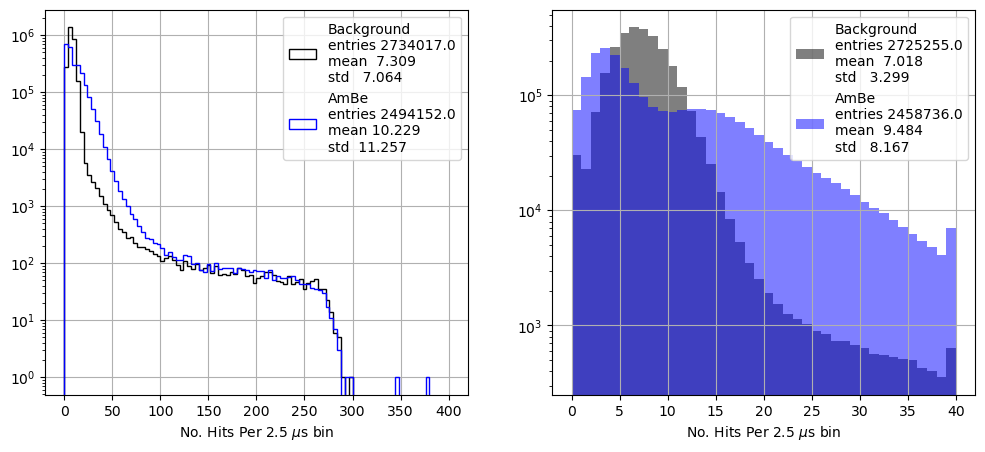

In [70]:
subplot = pltext.canvas(2)

subplot(1)
pltext.hist(bkg_no_hits_per_bin,  100, ylog=True, range=(0, 400), xylabels="No. Hits Per 2.5 $\mu$s bin", label="Background");
pltext.hist(ambe_no_hits_per_bin, 100, ylog=True, range=(0, 400), xylabels="No. Hits Per 2.5 $\mu$s bin", label="AmBe");

subplot(2)
pltext.hist(bkg_no_hits_per_bin,  40, ylog=True, range=(0, 40), xylabels="No. Hits Per 2.5 $\mu$s bin", histtype="stepfilled", alpha=0.5, label="Background");
pltext.hist(ambe_no_hits_per_bin, 40, ylog=True, range=(0, 40), xylabels="No. Hits Per 2.5 $\mu$s bin", histtype="stepfilled", alpha=0.5, label="AmBe");

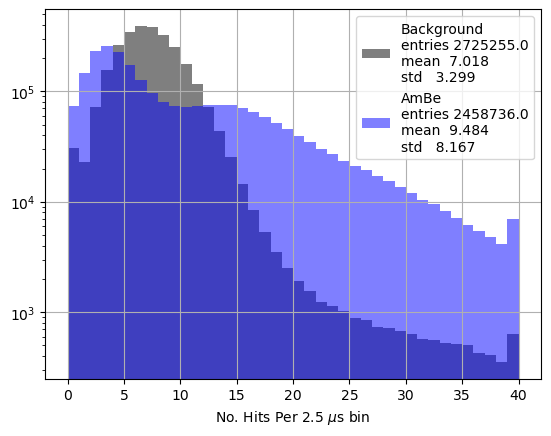

In [71]:
pltext.hist(bkg_no_hits_per_bin,  40, ylog=True, range=(0, 40), xylabels="No. Hits Per 2.5 $\mu$s bin", histtype="stepfilled", alpha=0.5, label="Background");
pltext.hist(ambe_no_hits_per_bin, 40, ylog=True, range=(0, 40), xylabels="No. Hits Per 2.5 $\mu$s bin", histtype="stepfilled", alpha=0.5, label="AmBe");

In [25]:
bkg_no_hits_per_bin  = np.concatenate([np.histogram(bkg_corrected_run_times_sorted[ev],  180)[0] for ev in tqdm(range(len(bkg_run_times_sorted)),  total=len(bkg_run_times_sorted))])
ambe_no_hits_per_bin = np.concatenate([np.histogram(ambe_corrected_run_times_sorted[ev], 180)[0] for ev in tqdm(range(len(ambe_run_times_sorted)), total=len(ambe_run_times_sorted))])

  0%|          | 0/25315 [00:00<?, ?it/s]

  0%|          | 0/23094 [00:00<?, ?it/s]

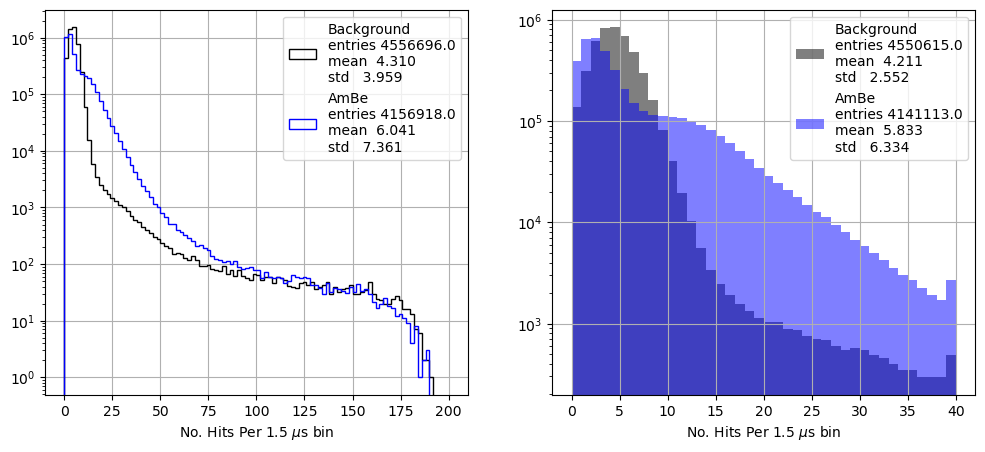

In [28]:
subplot = pltext.canvas(2)

subplot(1)
pltext.hist(bkg_no_hits_per_bin,  100, ylog=True, range=(0, 200), xylabels="No. Hits Per 1.5 $\mu$s bin", label="Background");
pltext.hist(ambe_no_hits_per_bin, 100, ylog=True, range=(0, 200), xylabels="No. Hits Per 1.5 $\mu$s bin", label="AmBe");

subplot(2)
pltext.hist(bkg_no_hits_per_bin,  40, ylog=True, range=(0, 40), xylabels="No. Hits Per 1.5 $\mu$s bin", histtype="stepfilled", alpha=0.5, label="Background");
pltext.hist(ambe_no_hits_per_bin, 40, ylog=True, range=(0, 40), xylabels="No. Hits Per 1.5 $\mu$s bin", histtype="stepfilled", alpha=0.5, label="AmBe");

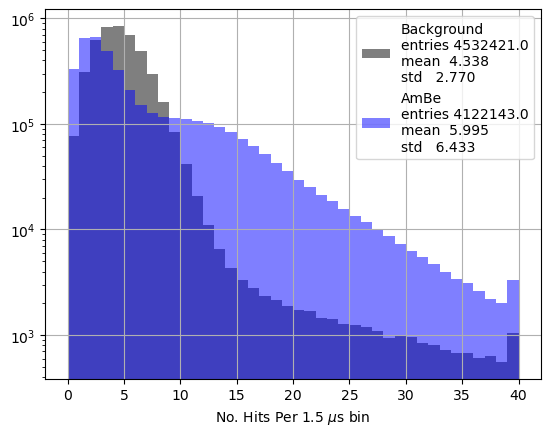

In [24]:
pltext.hist(bkg_no_hits_per_bin,  40, ylog=True, range=(0, 40), xylabels="No. Hits Per 1.5 $\mu$s bin", histtype="stepfilled", alpha=0.5, label="Background");
pltext.hist(ambe_no_hits_per_bin, 40, ylog=True, range=(0, 40), xylabels="No. Hits Per 1.5 $\mu$s bin", histtype="stepfilled", alpha=0.5, label="AmBe");

### Studies Applying The nHits Algorithm. Characterization Of The Triggered Signal.

In [72]:
bkg_triggered_scint_hits_index  = nHits(mode="multiple_events", hit_times=bkg_corrected_run_times_sorted,  w=1500, thresh_min=100, thresh_max=np.inf, pre_window=500, post_window=500, jump=2500)
ambe_triggered_scint_hits_index = nHits(mode="multiple_events", hit_times=ambe_corrected_run_times_sorted, w=1500, thresh_min=100, thresh_max=np.inf, pre_window=500, post_window=500, jump=2500)

100%|██████████| 23094/23094 [00:03<00:00, 6238.04it/s]


Cantas veces trigga no centelleo o algoritmo?

In [30]:
bkg_total_no_scint_triggers  = [len(bkg_triggered_scint_hits_index.get(key)) for key, value in bkg_triggered_scint_hits_index.items()]
ambe_total_no_scint_triggers = [len(ambe_triggered_scint_hits_index.get(key)) for key, value in ambe_triggered_scint_hits_index.items()]

In [31]:
np.sum(bkg_total_no_scint_triggers), np.sum(ambe_total_no_scint_triggers)

(2936, 4351)

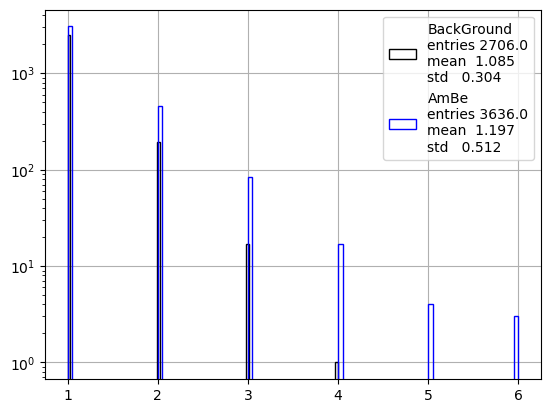

In [32]:
pltext.hist(bkg_total_no_scint_triggers,  100, ylog=True, label="BackGround");
pltext.hist(ambe_total_no_scint_triggers, 100, ylog=True, label="AmBe");

In [35]:
thresholds = np.arange(50, 250, 10)
sum_scint_bkg  = []
sum_scint_ambe = []

for th in tqdm(thresholds, total=len(thresholds)):
    bkg_triggered_scint_hits_index  = nHits(mode="multiple_events", hit_times=bkg_corrected_run_times_sorted,  w=1500, thresh_min=th, thresh_max=np.inf, pre_window=500, post_window=500, jump=2500, progress_bar=False)
    ambe_triggered_scint_hits_index = nHits(mode="multiple_events", hit_times=ambe_corrected_run_times_sorted, w=1500, thresh_min=th, thresh_max=np.inf, pre_window=500, post_window=500, jump=2500, progress_bar=False)

    bkg_total_no_scint_triggers  = [len(bkg_triggered_scint_hits_index.get(key)) for key, value in bkg_triggered_scint_hits_index.items()]
    ambe_total_no_scint_triggers = [len(ambe_triggered_scint_hits_index.get(key)) for key, value in ambe_triggered_scint_hits_index.items()]

    sum_scint_bkg.append(np.sum(bkg_total_no_scint_triggers))
    sum_scint_ambe.append(np.sum(ambe_total_no_scint_triggers))

  0%|          | 0/20 [00:00<?, ?it/s]

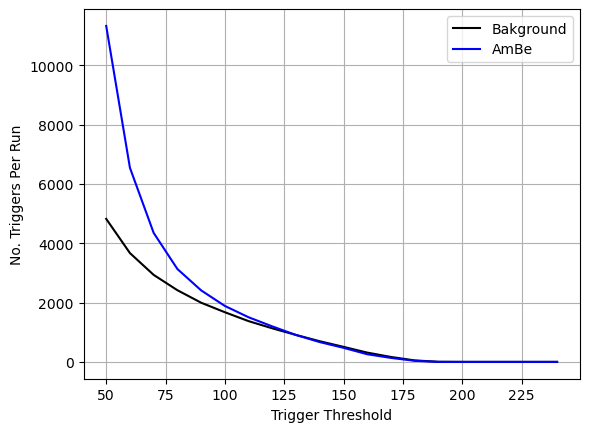

In [36]:
plt.plot(thresholds, sum_scint_bkg,  label="Bakground");
plt.plot(thresholds, sum_scint_ambe, label="AmBe");

plt.xlabel("Trigger Threshold")
plt.ylabel("No. Triggers Per Run")

plt.grid(True)

plt.legend();

### Characterization Of Triggered Scintillation Signal

In [87]:
bkg_triggered_scint_hits_index  = nHits(mode="multiple_events", hit_times=bkg_corrected_run_times_sorted,  w=1500, thresh_min=50, thresh_max=np.inf, pre_window=500, post_window=500, jump=2500, progress_bar=False)
ambe_triggered_scint_hits_index = nHits(mode="multiple_events", hit_times=ambe_corrected_run_times_sorted, w=1500, thresh_min=50, thresh_max=np.inf, pre_window=500, post_window=500, jump=2500, progress_bar=False)

In [88]:
ambe_triggered_scint_hits_index.keys()

dict_keys([9, 14, 31, 33, 34, 38, 40, 41, 44, 46, 51, 54, 56, 57, 67, 71, 72, 78, 86, 87, 89, 93, 98, 100, 108, 111, 117, 119, 120, 126, 130, 132, 137, 151, 152, 154, 159, 171, 172, 174, 176, 179, 182, 183, 185, 186, 187, 194, 201, 202, 204, 214, 220, 227, 228, 232, 233, 235, 250, 251, 252, 255, 256, 257, 259, 263, 277, 281, 282, 284, 285, 295, 299, 303, 307, 310, 311, 314, 322, 323, 324, 325, 328, 331, 340, 341, 345, 347, 348, 352, 353, 355, 357, 368, 372, 374, 376, 378, 386, 389, 395, 399, 401, 402, 406, 409, 422, 428, 430, 437, 442, 450, 452, 454, 466, 468, 469, 472, 475, 476, 477, 478, 489, 490, 492, 493, 495, 505, 508, 511, 513, 527, 528, 531, 532, 533, 534, 536, 537, 538, 540, 551, 554, 555, 557, 561, 567, 572, 576, 582, 591, 592, 594, 595, 601, 607, 614, 626, 633, 635, 636, 639, 640, 643, 648, 649, 650, 651, 653, 657, 662, 667, 670, 673, 676, 678, 681, 682, 683, 684, 686, 690, 693, 702, 703, 706, 708, 714, 716, 718, 721, 722, 724, 727, 731, 734, 736, 739, 744, 758, 759, 765, 766

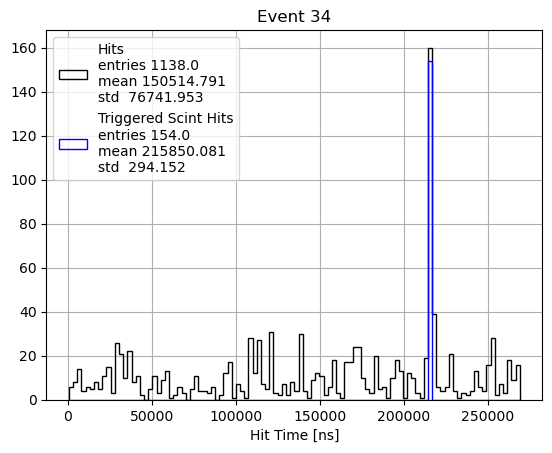

In [89]:
event = 34
data  = ambe_corrected_run_times_sorted[event]

pltext.hist(data,                                                             108, range=(data[0], data[-1]), xylabels="Hit Time [ns]", label=f"Hits");
pltext.hist(data[np.concatenate(ambe_triggered_scint_hits_index.get(event))], 108, range=(data[0], data[-1]), xylabels="Hit Time [ns]", label=f"Triggered Scint Hits");

plt.title(f"Event {event}");

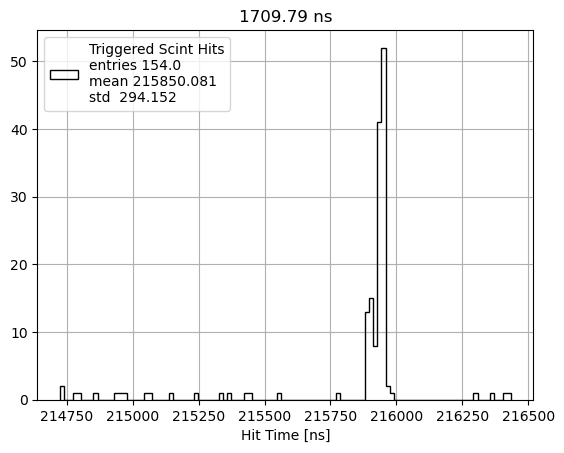

In [90]:
pltext.hist(data[np.concatenate(ambe_triggered_scint_hits_index.get(event))], 108,  xylabels="Hit Time [ns]", label=f"Triggered Scint Hits");
plt.title(f"{data[np.concatenate(ambe_triggered_scint_hits_index.get(event))][-1] - data[np.concatenate(ambe_triggered_scint_hits_index.get(event))][0]:.2f} ns");

In [91]:
no_scint_hits     = []
scint_pulse_width = []
for key, values in tqdm(ambe_triggered_scint_hits_index.items(), total=len(ambe_triggered_scint_hits_index.items())):
    data = ambe_corrected_run_times_sorted[key]
    for i in ambe_triggered_scint_hits_index.get(key):
        triggered_hits = data[ambe_triggered_scint_hits_index.get(key)[0]]

        no_scint_hits    .append(len(triggered_hits)) 
        scint_pulse_width.append(triggered_hits[-1] - triggered_hits[0])

  0%|          | 0/7397 [00:00<?, ?it/s]

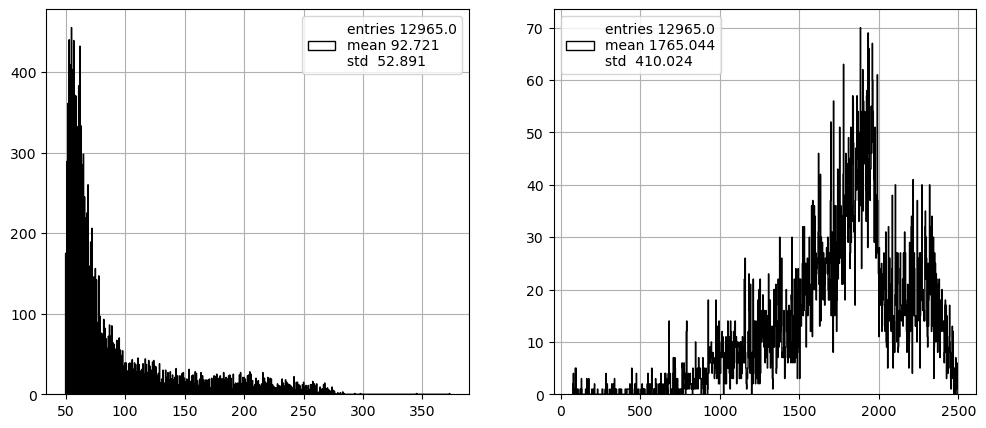

In [92]:
subplot = pltext.canvas(2)

subplot(1)
pltext.hist(no_scint_hits, 1000);

subplot(2)
pltext.hist(scint_pulse_width, 1000);

In [93]:
bkg_triggered_scint_hits_index.keys()

dict_keys([0, 4, 10, 24, 30, 31, 34, 39, 49, 70, 77, 83, 87, 90, 96, 102, 118, 122, 130, 133, 136, 140, 141, 155, 158, 178, 180, 185, 194, 210, 215, 217, 219, 220, 224, 231, 234, 237, 241, 248, 253, 259, 263, 267, 268, 275, 279, 286, 298, 299, 300, 301, 306, 308, 316, 318, 321, 334, 340, 346, 349, 350, 359, 362, 363, 364, 365, 384, 387, 390, 394, 400, 404, 414, 420, 423, 426, 432, 435, 436, 442, 445, 448, 454, 459, 463, 464, 470, 475, 483, 484, 486, 490, 501, 503, 504, 505, 506, 523, 527, 529, 537, 555, 558, 562, 569, 578, 580, 588, 598, 604, 620, 633, 635, 636, 642, 649, 655, 657, 660, 662, 665, 676, 684, 696, 697, 698, 699, 700, 705, 721, 727, 730, 734, 742, 745, 747, 749, 751, 752, 753, 759, 763, 766, 767, 771, 772, 776, 778, 780, 781, 799, 803, 805, 806, 831, 837, 840, 841, 842, 845, 850, 852, 856, 861, 869, 876, 878, 879, 880, 886, 893, 896, 903, 905, 910, 926, 930, 936, 937, 940, 952, 956, 958, 965, 967, 972, 976, 978, 985, 986, 987, 990, 992, 1007, 1015, 1016, 1017, 1019, 1028, 

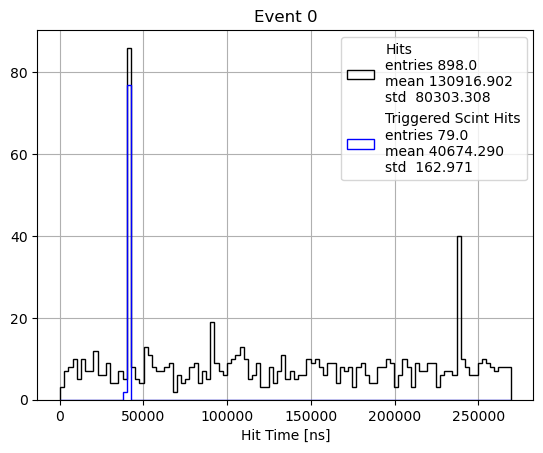

In [96]:
event = 0
data  = bkg_corrected_run_times_sorted[event]

pltext.hist(data,                                                            108, range=(data[0], data[-1]), xylabels="Hit Time [ns]", label=f"Hits");
pltext.hist(data[np.concatenate(bkg_triggered_scint_hits_index.get(event))], 108, range=(data[0], data[-1]), xylabels="Hit Time [ns]", label=f"Triggered Scint Hits");

plt.title(f"Event {event}");

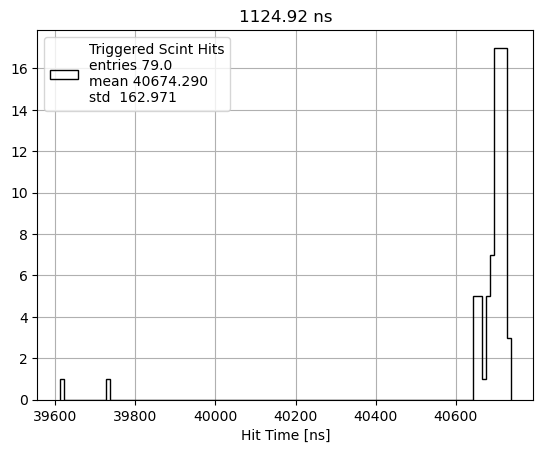

In [97]:
pltext.hist(data[np.concatenate(bkg_triggered_scint_hits_index.get(event))], 108,  xylabels="Hit Time [ns]", label=f"Triggered Scint Hits");
plt.title(f"{data[np.concatenate(bkg_triggered_scint_hits_index.get(event))][-1] - data[np.concatenate(bkg_triggered_scint_hits_index.get(event))][0]:.2f} ns");

In [99]:
no_scint_hits     = []
scint_pulse_width = []
for key, values in tqdm(bkg_triggered_scint_hits_index.items(), total=len(bkg_triggered_scint_hits_index.items())):
    data = bkg_corrected_run_times_sorted[key]
    for i in bkg_triggered_scint_hits_index.get(key):
        triggered_hits = data[bkg_triggered_scint_hits_index.get(key)[0]]

        no_scint_hits    .append(len(triggered_hits)) 
        scint_pulse_width.append(triggered_hits[-1] - triggered_hits[0])

  0%|          | 0/5006 [00:00<?, ?it/s]

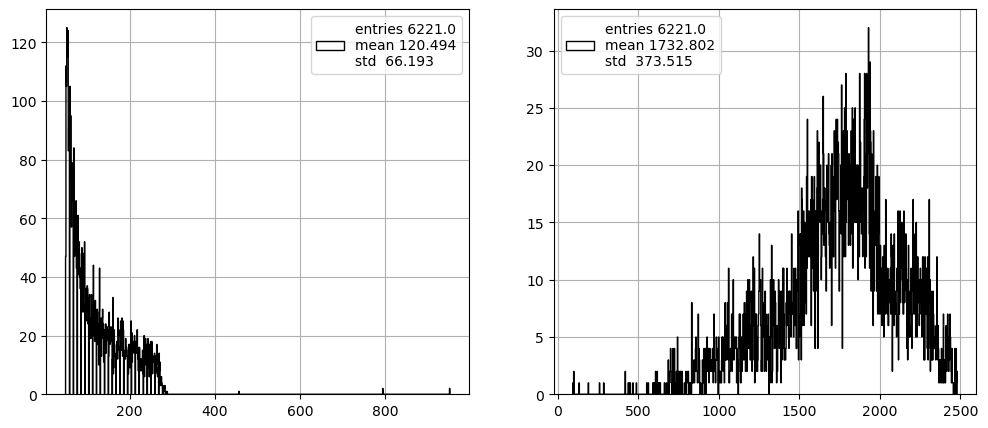

In [100]:
subplot = pltext.canvas(2)

subplot(1)
pltext.hist(no_scint_hits, 1000);

subplot(2)
pltext.hist(scint_pulse_width, 1000);